In [81]:
import pandas as pd

# Lire le fichier CSV

df = pd.read_csv('Online_Retail.csv', sep=';', decimal=',', encoding='latin1')
df.columns = df.columns.str.strip()

# Afficher les premières lignes du DataFrame
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45,0.65,12583.0,France


In [92]:

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Nettoyage
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # Supprimer les annulations
df = df.dropna(subset=['CustomerID', 'UnitPrice'])  # Supprimer les NaN
df['CustomerID'] = df['CustomerID'].astype(int)
df = df[df['Quantity'] > 0]

# Supprimer les outliers 
df = df[(df['UnitPrice'] < 100) & (df['Quantity'] < 1000)].copy()  
# Feature Engineering
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
# Feature Engineering
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceMonth'] = df['InvoiceDate'].dt.month

# Afficher les 5 premiers lignes après nettoyage
df_clean.head()




,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,671,24,2010-12-01 08:45:00,3.75,12583.0,France
1,536370,22727,686,24,2010-12-01 08:45:00,3.75,12583.0,France
2,536370,22726,630,12,2010-12-01 08:45:00,3.75,12583.0,France
3,536370,21724,902,12,2010-12-01 08:45:00,0.85,12583.0,France
4,536370,21883,1365,24,2010-12-01 08:45:00,0.65,12583.0,France



Performance du modèle:
RMSE: 0.13
R²: 1.00
MAE: 0.02


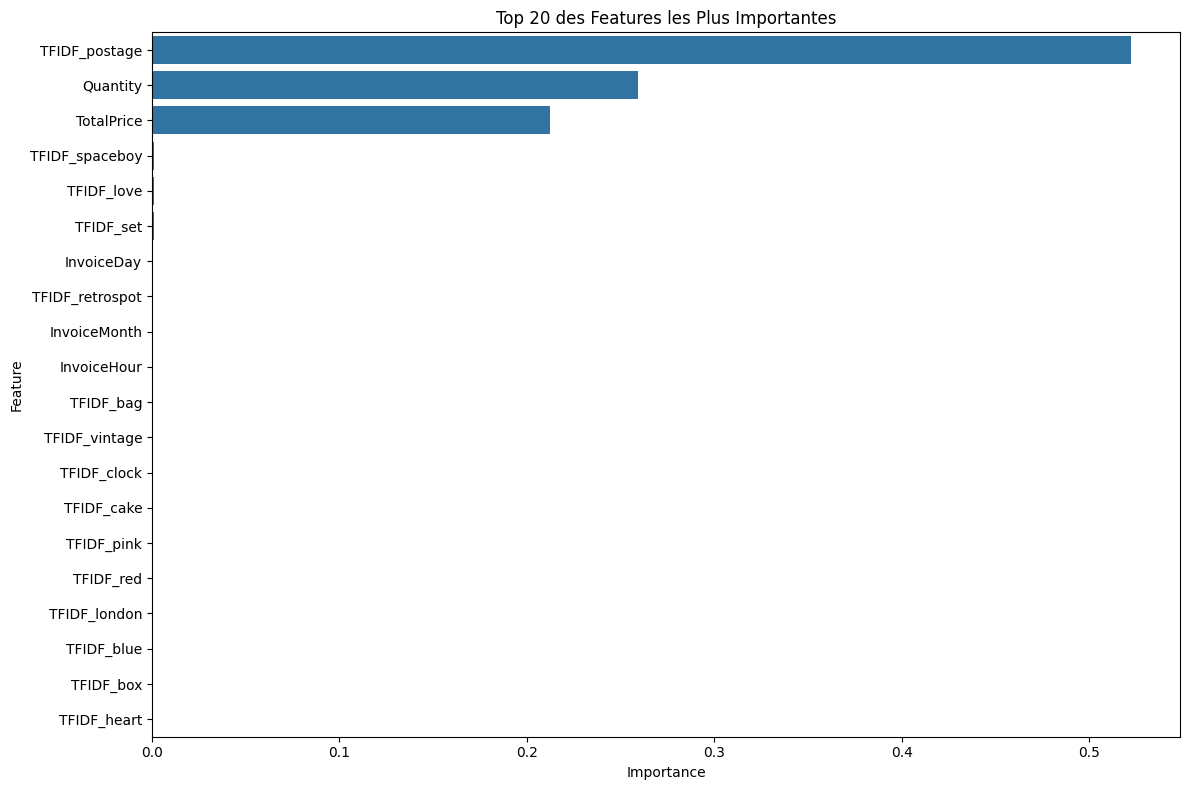

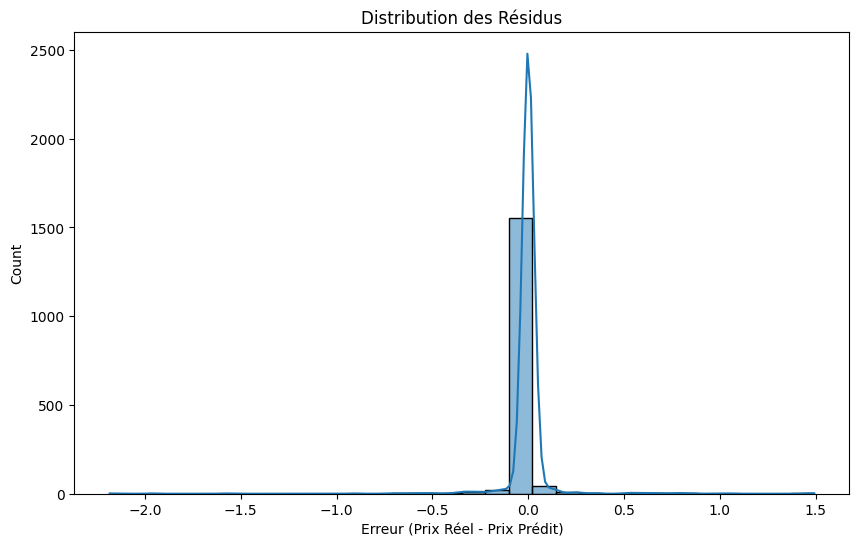


Modèle et artefacts sauvegardés:
- price_predictor_model.joblib
- scaler.joblib
- tfidf_vectorizer.joblib
- feature_importances.png
- residuals_distribution.png


In [93]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# Préparation des features

tfidf = TfidfVectorizer(max_features=50, stop_words='english')
X_text = tfidf.fit_transform(df['Description'].astype(str))

# Création du DataFrame avec les noms des features
X = pd.DataFrame(X_text.toarray(), 
                columns=[f"TFIDF_{i}" for i in tfidf.get_feature_names_out()], 
                index=df.index)

# Ajout des autres features
X = pd.concat([
    X,
    df[['Quantity', 'TotalPrice', 'InvoiceHour', 'InvoiceDay', 'InvoiceMonth']],
    pd.get_dummies(df['Country'], prefix='Country')
], axis=1)

# 3. Target et filtrage des outliers
y = df['UnitPrice']
condition = (X['Quantity'] < 1000) & (y < 100)
X = X[condition]
y = y[condition]

# 4. Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Entraînement du modèle
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

# Évaluation
y_pred = model.predict(X_test_scaled)
print("\nPerformance du modèle:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

#  Feature Importance
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', 
            data=importance_df.head(20))
plt.title("Top 20 des Features les Plus Importantes")
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()

#  Analyse des résidus
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution des Résidus")
plt.xlabel("Erreur (Prix Réel - Prix Prédit)")
plt.savefig('residuals_distribution.png')
plt.show()

#  Sauvegarde des artefacts
joblib.dump(model, 'price_predictor_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

print("\nModèle et artefacts sauvegardés:")
print("- price_predictor_model.joblib")
print("- scaler.joblib") 
print("- tfidf_vectorizer.joblib")
print("- feature_importances.png")
print("- residuals_distribution.png")


=== Métriques de Performance ===
RMSE: 0.1315
R²: 0.9988
MAE: 0.0238
Accuracy (avec marge de 10.0%): 98.56%


C:\Users\Admin\AppData\Local\Temp\ipykernel_15448\3821366895.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

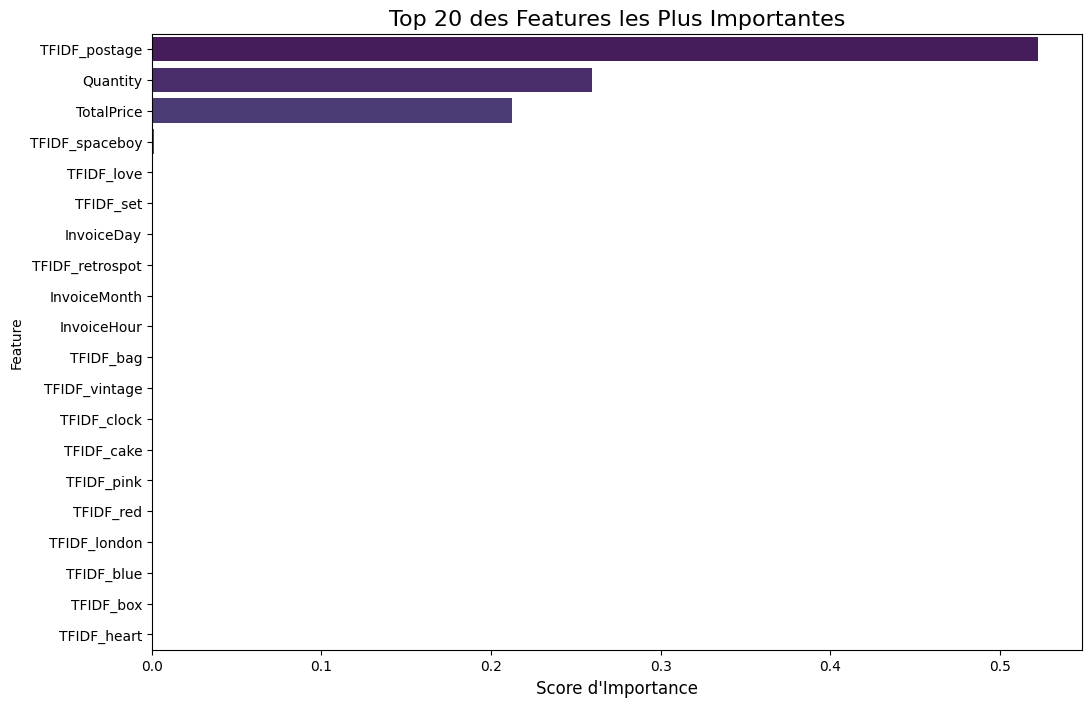

In [96]:
# Évaluation des performances
print("\n=== Métriques de Performance ===")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# Accuracy adaptée pour la régression (pourcentage de prédictions dans une marge d'erreur)
error_margin = 0.1  # 10% de marge d'erreur
accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < error_margin) * 100
print(f"Accuracy (avec marge de {error_margin*100}%): {accuracy:.2f}%")

# Feature Importance
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Top 20 des Features les Plus Importantes", fontsize=16)
plt.xlabel("Score d'Importance", fontsize=12)
plt.ylabel


In [97]:
import joblib

# Sauvegarde du modèle
joblib.dump(model, 'model.joblib')

print("Modèle sauvegardé sous 'model.joblib'")

Modèle sauvegardé sous 'model.joblib'
